<a href="https://colab.research.google.com/github/CorsiDanilo/big-data-computing-project/blob/main/BDC_Project_Bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin price forecasting with PySpark
## Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author
Corsi Danilo - corsi.1742375@studenti.uniroma1.it



### Introduction

The cryptocurrency Bitcoin has attracted the attention of many people in recent years. However, it's
price fluctuation can be extremely unpredictable, which makes it difficult to predict when the right
time to buy or sell this digital currency will be. In this context, forecasting Bitcoin prices can be a
competitive advantage for investors and traders, as it could allow them to make informed decisions
on the right time to enter or exit the market. In this project, I will analyze some machine learning
techniques to understand, through the processing of historical data, how accurately the price of Bitcoin
can be predicted and whether this can provide added value to cryptocurrency investors and traders.
### Dataset
I chose to use the following dataset from Kaggle Bitcoin Historical Dataset, more specifically those
containing minute-by-minute updates of the Bitcoin price from 2017 to 2021 (period for which there
were moments of high volatility but also a lot of price lateralisation). The columns (features) contained
in it, in addition to the timestamp of each transaction, are the opening, closing, highest and lowest
price and the corresponding trading volume in Bitcoin and Dollars.
### Methods (TODO: da scegliere per bene)
The methods I will test will be Linear Regression (simple and multiple) and Random Forest. Further
comparisons with other classification models are planned in the course of development. Moreover, I
would also like to try to understand what the differences are between these methods and the imple-
mentation of a state-of-the-art neural network such as Long-Short Term Memory.
### Evaluation framework (TODO: vedi quali usare in base ai paper/esempi e ai modelli utilizzati)
As evaluation framework I will use R-square (R²), Mean Square Error (MSE) and Mean Absolute
Error (MAE) to get a complete picture of the performance of the various models.

# **Spark + Google Colab Setup**

## **0.** Global Constants


In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_DATASET_DIR = GDRIVE_DIR + "/MyDrive/Computer_Science/BDC/project/datasets"

GDRIVE_DATASET = GDRIVE_DATASET_DIR + "/BTC-2017_2021.csv"

RANDOM_SEED = 42 # for reproducibility

## **1.** Install PySpark and related dependencies





In [2]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=74cea0b4dceadf73edfac03f728d1585a4a051d6d35693866bf43b1d591bcfd2
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## **2.** Import useful Python packages

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from itertools import cycle

import plotly.express as px

from pyspark.sql import functions as F

## **3.** Create Spark context

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("BitcoinPricePrediction").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Create <code>ngrok</code> tunnel to check the Spark UI

In [5]:
# Install ngrok
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=1303d92c49730020bfade239936e6e898f3f077353c6c5890f91f599b46d2f0d
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [6]:
# Saving authtoken 
!ngrok authtoken 2PKOO1E6Ghw65dpEG4QNSVzu9PY_GufsrTiussGmBxF664RD 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [7]:
from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

In [8]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://d719-34-73-201-26.ngrok-free.app" -> "http://127.0.0.1:4050"


## **5.** Link Colab to our Google Drive

In [9]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


## **6.** Check everything is ok

In [10]:
spark

In [11]:
sc._conf.getAll()

[('spark.app.submitTime', '1684579806397'),
 ('spark.driver.host', 'bcc662e97acf'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.id', 'local-1684579810184'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java

# **Dataset, processing and feature extraction**

In this section we are going to explore the dataset, to clean it from null values, and to determine which features are relevant and which are not.

## **1.** Data cleaning

First, we import the dataset from Google Drive.

In [12]:
df = spark.read.load(GDRIVE_DATASET, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

Check the shape of the loaded dataset, i.e.,

In [13]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 2675301 rows by 9 columns


Print out the schema of the loaded dataset

In [14]:
df.printSchema()
df.show(5)	

# showing the last 5 rows
from pyspark.sql.functions import desc
from pyspark.sql.functions import monotonically_increasing_id
df.withColumn("index", monotonically_increasing_id()).orderBy(desc("index")).drop("index").show(5)	

root
 |-- unix: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- symbol: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USD: double (nullable = true)

+----------+-------------------+-------+--------+--------+--------+--------+----------+----------------+
|      unix|               date| symbol|    open|    high|     low|   close|Volume BTC|      Volume USD|
+----------+-------------------+-------+--------+--------+--------+--------+----------+----------------+
|1514764740|2017-12-31 23:59:00|BTC/USD|13913.28|13913.28|13867.18| 13880.0|0.59174759|    8213.4565492|
|1514764680|2017-12-31 23:58:00|BTC/USD|13913.26|13953.83|13884.69|13953.77|1.39878396|19518.3096575292|
|1514764620|2017-12-31 23:57:00|BTC/USD|13908.73|13913.26|13874.99|13913.26|0.77501206|10782.9442939156|
|1514764560|2017-12-31

We can delete the "symbol" and "unix" column since we are not gonna use it and changing the name of "Volume BTC" and "Volume USD"


In [15]:
df = df.withColumnRenamed("Volume BTC","volume_btc") \
    .withColumnRenamed("Volume USD","volume_usd") \
    .drop("symbol") \
    .drop("unix")

df.printSchema()
df.show(5)	

root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume_btc: double (nullable = true)
 |-- volume_usd: double (nullable = true)

+-------------------+--------+--------+--------+--------+----------+----------------+
|               date|    open|    high|     low|   close|volume_btc|      volume_usd|
+-------------------+--------+--------+--------+--------+----------+----------------+
|2017-12-31 23:59:00|13913.28|13913.28|13867.18| 13880.0|0.59174759|    8213.4565492|
|2017-12-31 23:58:00|13913.26|13953.83|13884.69|13953.77|1.39878396|19518.3096575292|
|2017-12-31 23:57:00|13908.73|13913.26|13874.99|13913.26|0.77501206|10782.9442939156|
|2017-12-31 23:56:00| 13827.0|13908.69| 13827.0|13859.58|0.66645895|  9236.841134241|
|2017-12-31 23:55:00|13825.05|13825.05|13825.05|13825.05| 0.0655014|    905.56013007|
+-------------------+--------+--------+

Here, we can check how many Nan values we have in the dataset.

In [16]:
df.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df.columns
]).show()

+----+----+----+---+-----+----------+----------+
|date|open|high|low|close|volume_btc|volume_usd|
+----+----+----+---+-----+----------+----------+
|   0|   0|   0|  0|    0|         0|         0|
+----+----+----+---+-----+----------+----------+



We also reduce the columns in the DataFrame to two decimal places.

In [17]:
df = df.withColumn("open", round(df["open"], 2)) \
                    .withColumn("close", round(df["close"], 2)) \
                    .withColumn("high", round(df["high"], 2)) \
                    .withColumn("low", round(df["low"], 2)) \
                    .withColumn("volume_usd", round(df["volume_usd"], 2)
                  )
df.show(5)	                

+-------------------+--------+--------+--------+--------+----------+----------+
|               date|    open|    high|     low|   close|volume_btc|volume_usd|
+-------------------+--------+--------+--------+--------+----------+----------+
|2017-12-31 23:59:00|13913.28|13913.28|13867.18| 13880.0|0.59174759|   8213.46|
|2017-12-31 23:58:00|13913.26|13953.83|13884.69|13953.77|1.39878396|  19518.31|
|2017-12-31 23:57:00|13908.73|13913.26|13874.99|13913.26|0.77501206|  10782.94|
|2017-12-31 23:56:00| 13827.0|13908.69| 13827.0|13859.58|0.66645895|   9236.84|
|2017-12-31 23:55:00|13825.05|13825.05|13825.05|13825.05| 0.0655014|    905.56|
+-------------------+--------+--------+--------+--------+----------+----------+
only showing top 5 rows



## **2.** Exploring the data
Now, before building a model to predict the Bitcoin price, let's try a have a better visualization of the data.

Daily analysis of the price from 2017 to 2021

In [18]:
# Calculation of the average price for each day
daily_df = df.withColumn("date", date_format(df.date, "yyyy-MM-dd")).groupBy("date").agg(
    avg("open").alias("mean_open"),
    avg("close").alias("mean_close"),
    avg("high").alias("mean_high"),
    avg("low").alias("mean_low"),
    avg("volume_btc").alias("mean_volume_btc"),
    avg("volume_usd").alias("mean_volume_usd")
).sort("date")

# Reduce the columns in the DataFrame to two decimal places
daily_df = daily_df.withColumn("mean_open", round(daily_df["mean_open"], 2)) \
                    .withColumn("mean_close", round(daily_df["mean_close"], 2)) \
                    .withColumn("mean_high", round(daily_df["mean_high"], 2)) \
                    .withColumn("mean_low", round(daily_df["mean_low"], 2)) \
                    .withColumn("mean_volume_usd", round(daily_df["mean_volume_usd"], 2)
                    )

daily_df.show(5)	                

+----------+---------+----------+---------+--------+------------------+---------------+
|      date|mean_open|mean_close|mean_high|mean_low|   mean_volume_btc|mean_volume_usd|
+----------+---------+----------+---------+--------+------------------+---------------+
|2017-01-01|   977.26|    977.28|   977.39|  977.13| 4.760662479909663|        4701.83|
|2017-01-02|  1012.27|   1012.27|  1012.52| 1011.99| 5.671792382069449|        5747.24|
|2017-01-03|   1020.0|   1020.04|  1020.23| 1019.79| 6.312262517562504|        6442.18|
|2017-01-04|  1076.56|   1076.55|  1077.27| 1075.57| 14.97392845275002|       16303.13|
|2017-01-05|  1043.61|   1043.55|  1044.91| 1042.09|25.013097999937482|       25132.51|
+----------+---------+----------+---------+--------+------------------+---------------+
only showing top 5 rows



In [19]:
# convert the mean_df from PySpark to Pandas to be able to plot it more easly                    
daily_df_pandas = daily_df.toPandas()

In [20]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['mean_open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['mean_close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['mean_high'].astype(float),
    mode = 'lines',
    name = 'High'
)
trace4 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['mean_low'].astype(float),
    mode = 'lines',
    name = 'Low'
)

layout = dict(
    title='Historical Bitcoin Prices (2017 - 2021) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

Lets visualize Historical Bitcoin Market Volume (2017 - 2021)

In [21]:
trace1 = go.Scatter(
    x = daily_df_pandas['date'],
    y = daily_df_pandas['mean_volume_usd'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2017 - 2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [22]:
# TODO: check what happened between nov 23 2020 and dec 20 2020
start_date = '2020-11-23'
end_date = '2020-12-20'

filtered_df = daily_df_pandas[daily_df_pandas['date'].between(start_date, end_date)]

trace1 = go.Scatter(
    x = filtered_df['date'],
    y = filtered_df['mean_volume_usd'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2017-2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [23]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = daily_df_pandas['mean_volume_btc'].astype(float),
    x = daily_df_pandas['mean_volume_usd'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

## **3.** Model preparation (TODO: ❓)

First Step is Preparing Data for Training and Testing.
As we want to predict Close Price of the Bitcoin so we are just Considering Close aand Date

TODO: Since Bitcoin price has drastically flucated from 200 dollar in year 2014 to 15000 dollar in year 2018 to 3000 dollar in year 2019(theses values are apporx) so we will just consider 1 Year to avoid this type of flucation in the data.


In [24]:
# # Lets First Take all the Close Price 
# # df_pandas = df.toPandas()

# close_df = df_pandas[['date','close']]

# print("Shape of close dataframe:", close_df.shape)

**Normalizing Data**

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [25]:
# # deleting date column and normalizing using MinMax Scaler
# del close_df['date']

# from sklearn.preprocessing import MinMaxScaler

# scaler =  MinMaxScaler(feature_range=(0,1))
# close_df = scaler.fit_transform(np.array(close_df).reshape(-1,1))
# print(close_df.shape)


Slicing data into Training set and Testing set

In [26]:
# # we keep the training set as 60% and 40% testing set
# training_size=int(len(close_df)*0.60)
# test_size=len(close_df)-training_size
# train_data,test_data=close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
# print("train_data: ", train_data.shape)
# print("test_data: ", test_data.shape)

Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15


In [27]:
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])
#     return np.array(dataX), np.array(dataY)
# time_step = 15
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

# print("X_train: ", X_train.shape)
# print("y_train: ", y_train.shape)
# print("X_test: ", X_test.shape)
# print("y_test", y_test.shape)

In [28]:
# # reshape input to be [samples, time steps, features] which is required for LSTM
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# print("X_train: ", X_train.shape)
# print("X_test: ", X_test.shape)

### 3.4 Feature Selection (TODO: serve ?)

The aim of this section is to remove the features that have less of an impact to the final result from the dataframe. This operation is called feature selection. Let's plot a correlation map to see how features are correlated among each other:

In [29]:
# df.corr().style.background_gradient(cmap="rocket_r")

Selecting the k=6 best features using SelectKBest and chi2 as score function.

In [30]:
# X_6_best= SelectKBest(chi2, k=6).fit(X_train, y_train)
# mask = X_6_best.get_support() #list of booleans for selected features
# new_feat = [] 
# removed_features = []
# for bool, feature in zip(mask, X_train.columns):
#     if bool:
#         new_feat.append(feature)
#     else:
#       removed_features.append(feature)
# print(f"The best features are:{new_feat}")
# print(f"Removed features: {removed_features}")

In [31]:
# df = df.drop(removed_features, axis = 1)
# df

# 4. Application of models

In [32]:
# convert the mean_df from PySpark to Pandas to be able to plot it more easly                    
df_pandas = df.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



In [33]:
# saving temp the pandas df into another variable
data = df_pandas

### **0.** LSTM (TODO: da sistemare)
In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [34]:
data['date'] = data['date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
data = data.set_index('date')
data = data[['close']]
data['close'].fillna(method='ffill', inplace=True)

For the train and test, we take '25-Jun-2018' as the split date. There was a considerable dip in Bitcoin prices between the June-July period 2018. If we check the historical prices the seasonal market started going up from this date after reaching the lowest, though the price reached much lower $5972 on June 29th 2018. After reaching the historic 20K mark on December 18th, there were several dips and market price was recorrected every time. Read more about Bitcoin dips.

In [35]:
# split data
split_date = '20-Jul-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [36]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

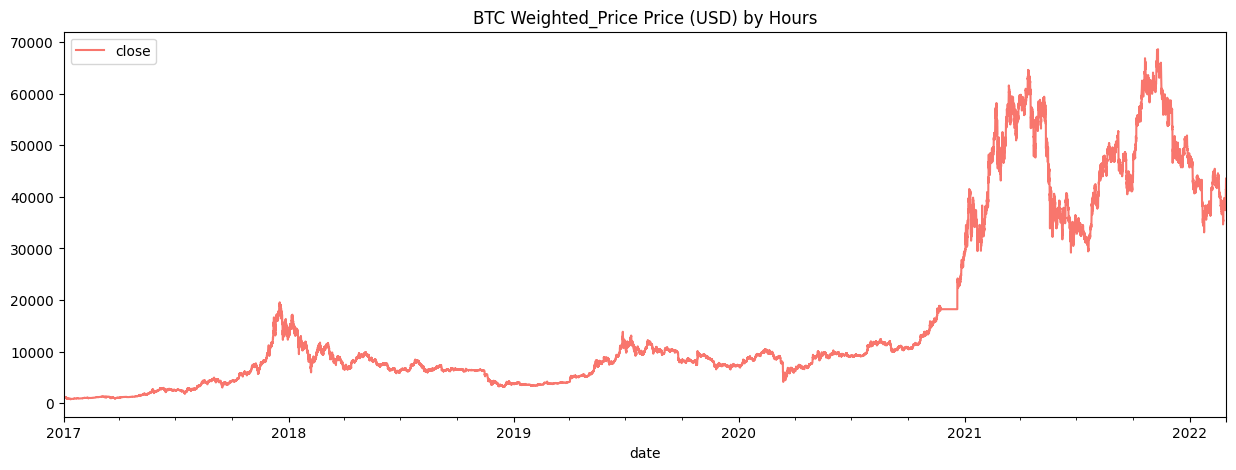

In [37]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

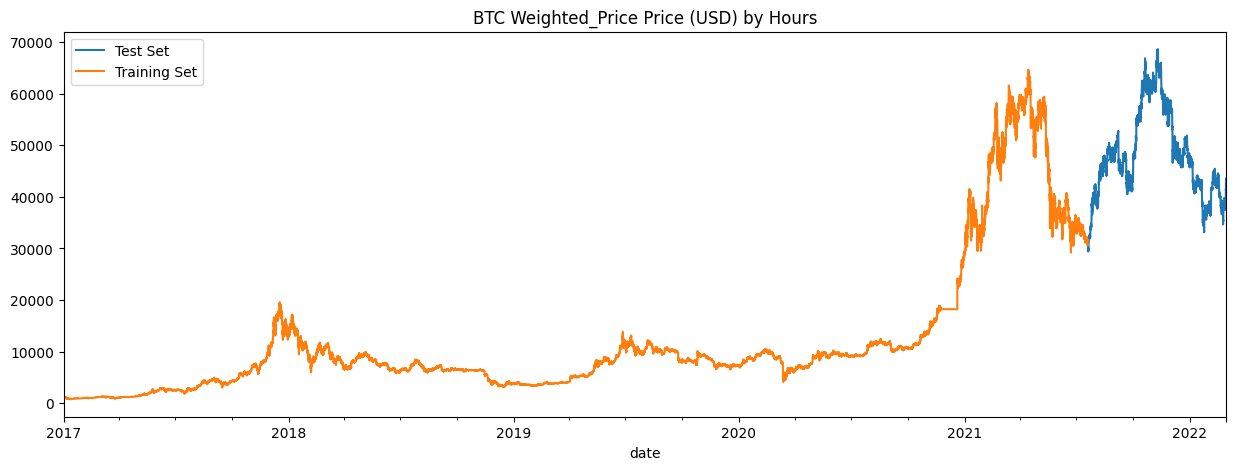

In [38]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.



In [39]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
798/798 - 5s - loss: 0.0365 - 5s/epoch - 6ms/step
Epoch 2/100
798/798 - 4s - loss: 0.0102 - 4s/epoch - 5ms/step
Epoch 3/100
798/798 - 4s - loss: 0.0057 - 4s/epoch - 5ms/step
Epoch 4/100
798/798 - 3s - loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 5/100
798/798 - 3s - loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 6/100
798/798 - 3s - loss: 0.0024 - 3s/epoch - 4ms/step
Epoch 7/100
798/798 - 5s - loss: 0.0019 - 5s/epoch - 6ms/step
Epoch 8/100
798/798 - 3s - loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 9/100
798/798 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 10/100
798/798 - 3s - loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 11/100
798/798 - 5s - loss: 0.0011 - 5s/epoch - 6ms/step
Epoch 12/100
798/798 - 3s - loss: 9.3623e-04 - 3s/epoch - 4ms/step
Epoch 13/100
798/798 - 3s - loss: 8.5249e-04 - 3s/epoch - 4ms/step
Epoch 14/100
798/798 - 3s - loss: 7.6311e-04 - 3s/epoch - 4ms/step
Epoch 15/100
798/798 - 4s - loss: 6.9920e-04 - 4s/epoch - 5ms/step
Epoch 16/100
798/798 - 4s - loss: 6.5857e-04 - 4

In [40]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

169/169 [==============================] - 1s 3ms/step


In [42]:
data_test['close_prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [43]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'close_prediction': 'lstm'})
final_data = final_data[['date','close','lstm']]

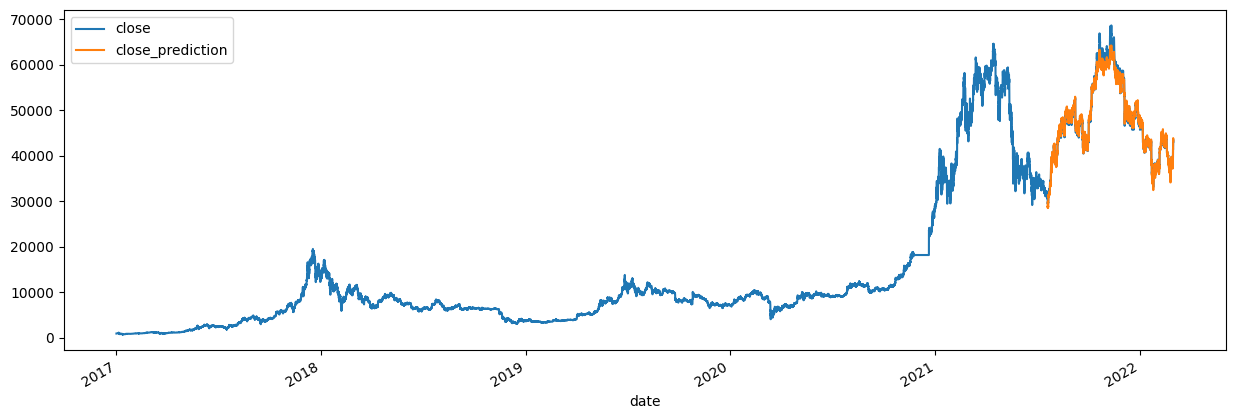

In [44]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))


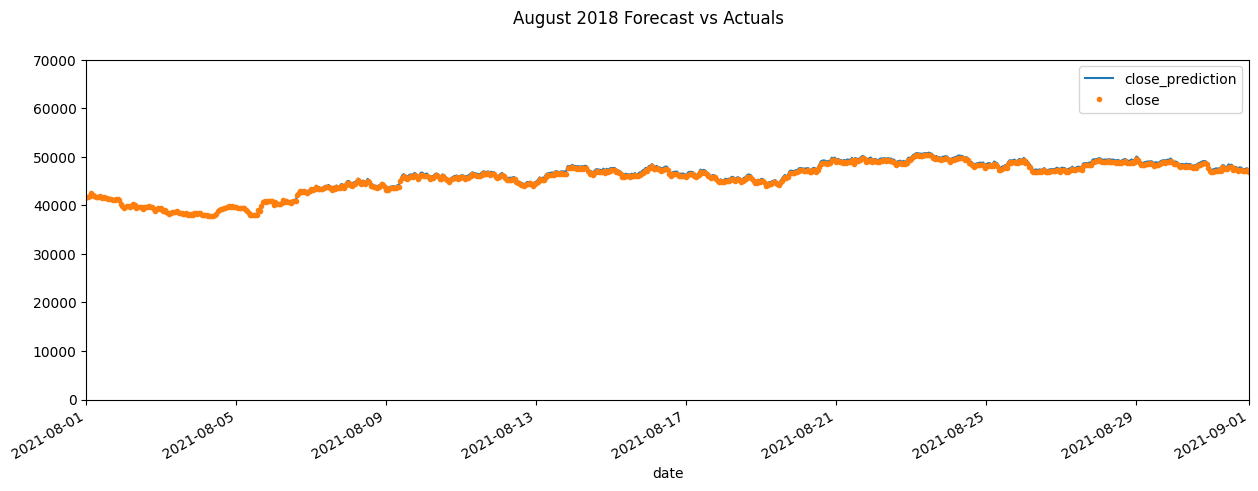

In [45]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

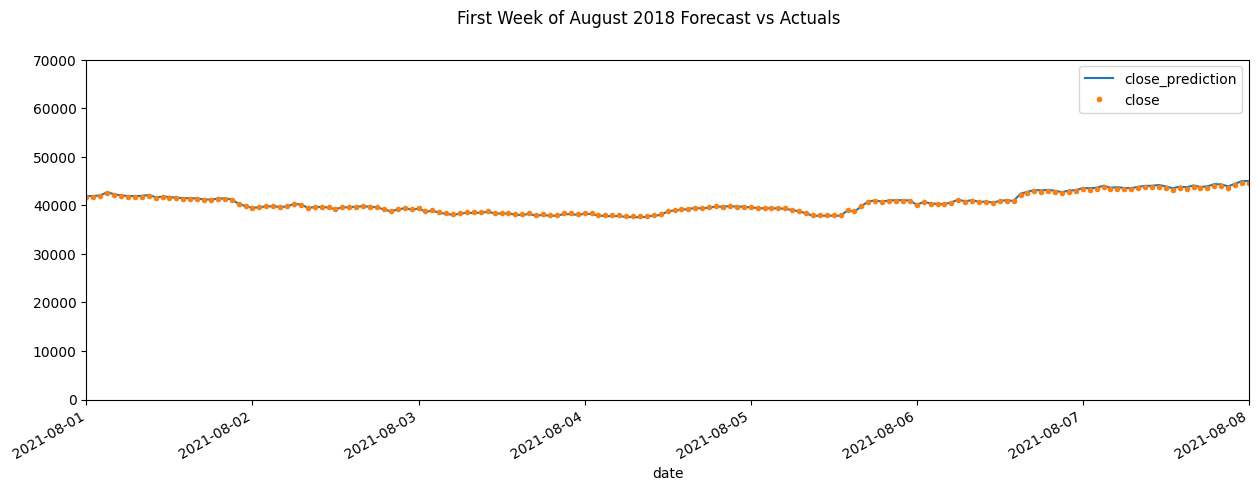

In [46]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [47]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

769368.1511175948

In [48]:
mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

577.1765881204685

We can clearly see the entire model is over-fitted.



### **1.** XGBoost (TODO: spiegare perché non hai scelto Random Forest)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a powerful and versatile tool. Lets see, How well does XGBoost perform when used to predict future values of a time-series like Bitcoin prices ?

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [51]:
# data['date'] = data['date'].dt.tz_localize(None)
# data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
# data = data.set_index('date')
# data = data[['close']]
# data['close'].fillna(method='ffill', inplace=True)

KeyError: ignored

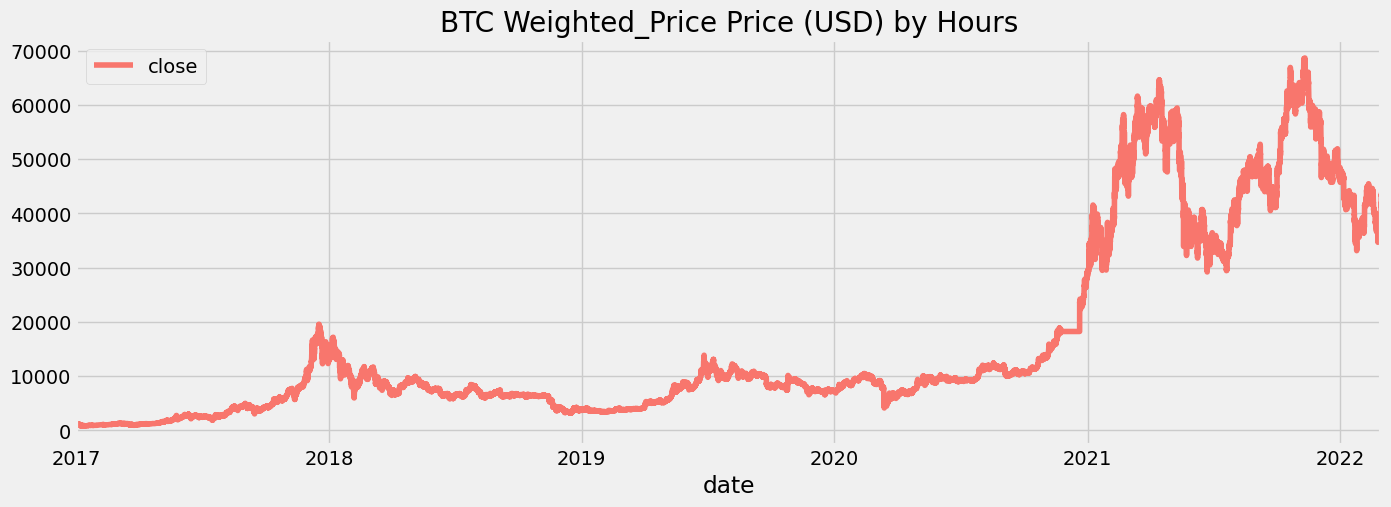

In [52]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [53]:
split_date = '20-Jul-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

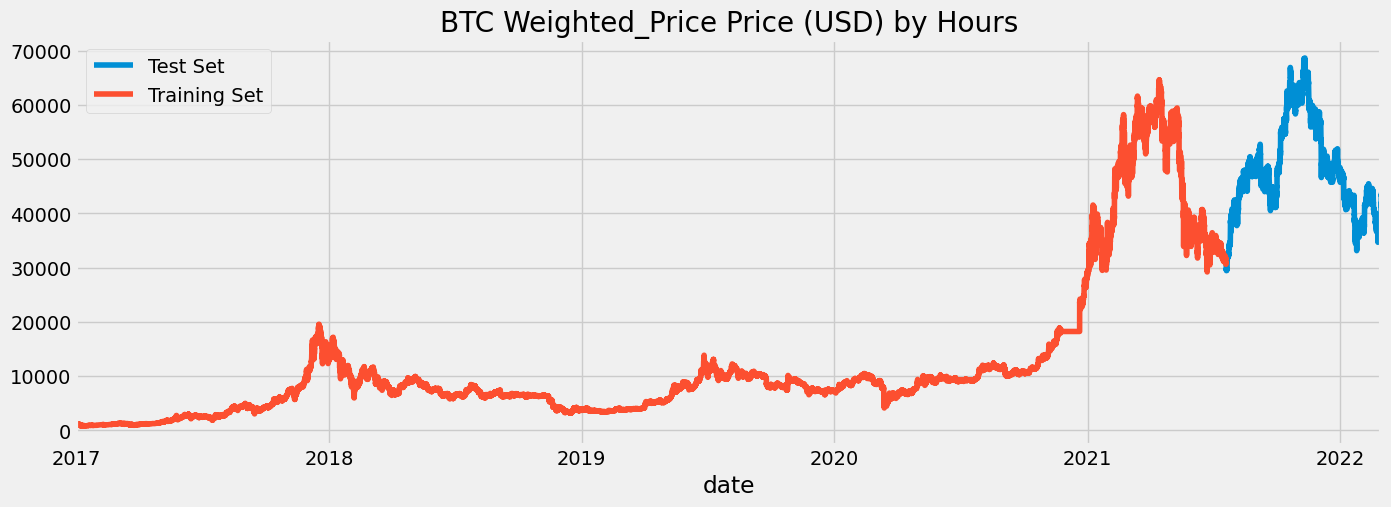

In [54]:
_ = data_test \
    .rename(columns={'close': 'Test Set'}) \
    .join(data_train.rename(columns={'close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [55]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [56]:
X_train, y_train = create_features(data_train, label='close')
X_test, y_test = create_features(data_test, label='close')

<ipython-input-55-568ff9107aea>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

<ipython-input-55-568ff9107aea>:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Here we use a basic XGBRegressor model,

In [57]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [58]:
data_test['close_prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [60]:
# # saving the predicted values in a common data frame for future comparision
# final_data = data_all
# final_data = final_data.reset_index()
# final_data = final_data.rename(columns={'close_rediction': 'xgboost'})
# final_data = final_data[['date','volume_usd_prediction','xgboost']]

ValueError: ignored

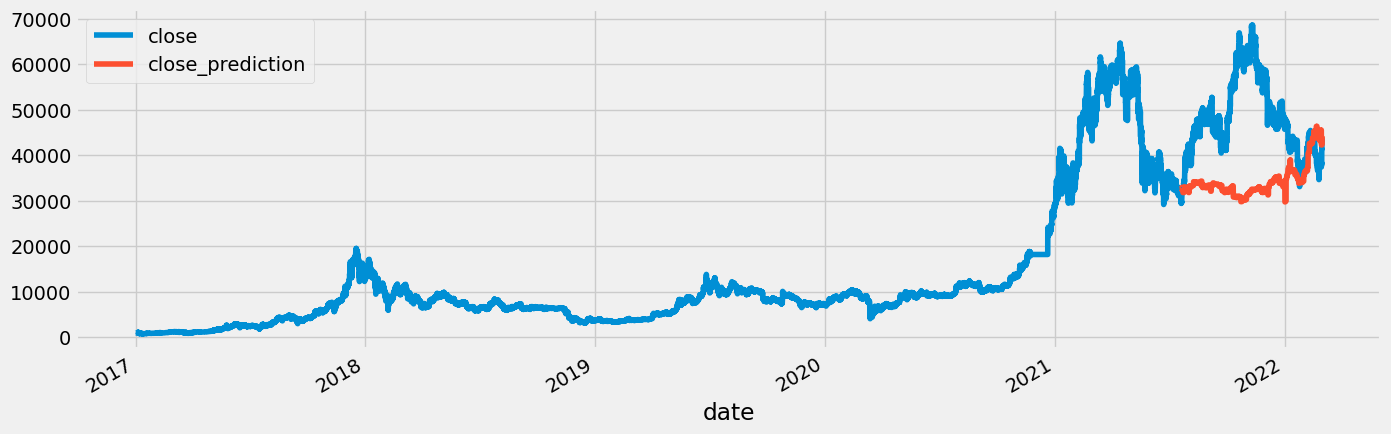

In [61]:
_ = data_all[['close','close_prediction']].plot(figsize=(15, 5))

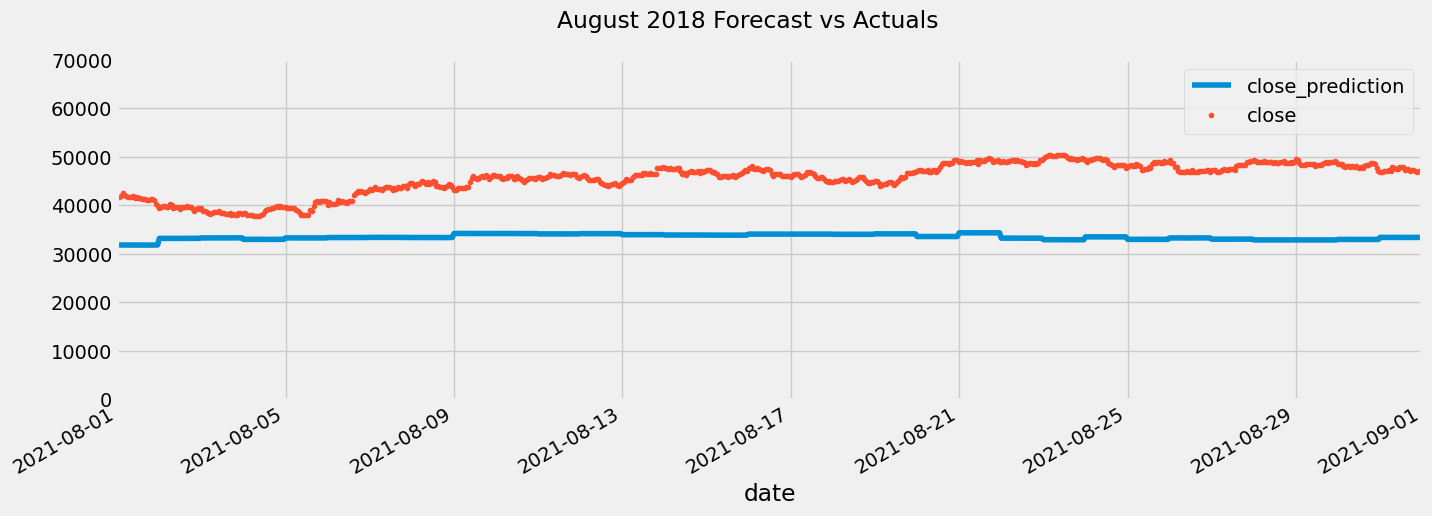

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='09-01-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

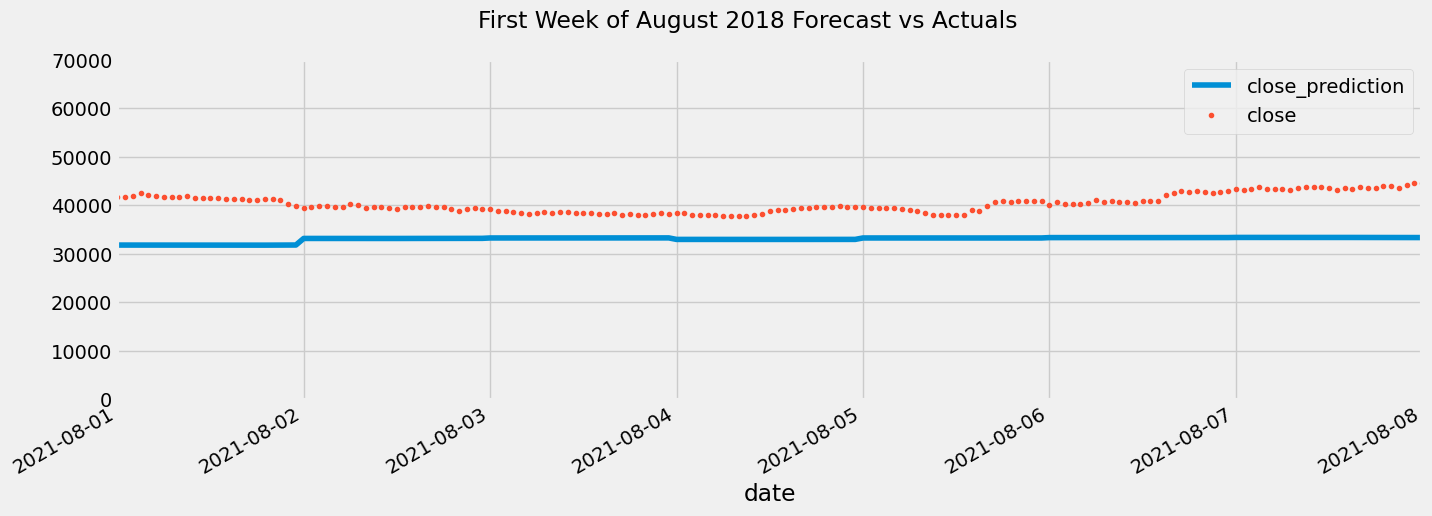

In [66]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['close_prediction','close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2021', upper='08-08-2021')
ax.set_ylim(0, 70000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

Evaluation

In [67]:
mean_squared_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

302863083.1683471

In [68]:
mean_absolute_error(y_true=data_test['close'],
                   y_pred=data_test['close_prediction'])

14489.618344778306

### 4.2 K-Nearest Neighbors


This is a possible implementation of KNN using Sklearn with an efficient selection of K value using GridSearchCV. The GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, we can select the best parameters from the listed hyperparameters.

In [ ]:
knn_grid = KNeighborsClassifier()

k_values= range(1, 20)

param_grid = {"n_neighbors": k_values, "weights": ['uniform', 'distance'], "metric": ['euclidean', 'manhattan']}

knn_grid_model = GridSearchCV(knn_grid, param_grid, cv = 10, scoring = 'recall', return_train_score = False)

knn_grid_model.fit(X_train, y_train)

best_recall = knn_grid_model.best_score_ * 100
best_param = knn_grid_model.best_params_

print("Best recall: {:.2f}%".format(best_recall))
print('Best parameter: ', best_param)

Best recall: 98.72%
Best parameter:  {'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}


By fitting the model with grid search we found out the optimal parameter of K with the best recall score.

In [ ]:
best_k = best_param["n_neighbors"]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

models_score.append(["KNN", accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)]) # KNN

Testing Accuracy: 76.71%
Testing Recall: 62.96%


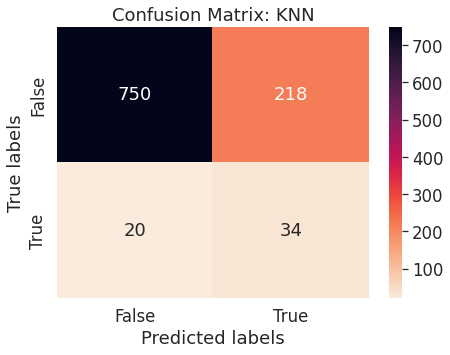

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf_matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: KNN')
sns.heatmap(cf_matrix, annot = True, fmt = "g", cmap = "rocket_r")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

print("Testing Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("Testing Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))

### 4.3 Gaussian Discriminant Analysis

We decided to apply both Linear Discriminant Analysis and Quadratid Discriminant Analysis in order to compare the performances.
Here are the parameters that we have to compute for the QDA:
- $\phi = P(y=1)$: the probability of a person having a stroke;
- $\mu_0$ the mean vector of the class 0 (person doesn't have a stroke);
- $\mu_1$ the mean vector of the class 1 (person does have a stroke);
- $\Sigma_0$ the covariance matrix relative to the class 0.
- $\Sigma_1$ the covariance matrix relative to the class 1.

Regarding the LDA, the parameters are the same but we only compute one covariance matrix $\sigma$ for both the classes.

In [ ]:
def qda_fit(X_train, y_train):
    mu_0 = np.mean(X_train[y_train == 0], axis=0) #Mean vector of class 0 (hasn't stroke)
    mu_1 = np.mean(X_train[y_train == 1], axis=0) #Mean vector of class 1 (has stroke)
    sigma_0 = np.cov(X_train[y_train == 0], rowvar=0) 
    sigma_1 = np.cov(X_train[y_train == 1], rowvar=0) 
    phi = float(np.sum(y_train)) / y_train.shape[0] #Probability of a person having a stroke
    return phi, mu_0, mu_1, sigma_0, sigma_1
  
def lda_fit(X_train, y_train):
    mu_0 = np.mean(X_train[y_train == 0], axis=0) #Mean vector of class 0 (hasn't stroke)
    mu_1 = np.mean(X_train[y_train == 1], axis=0) #Mean vector of class 1 (has stroke)
    sigma = np.cov(X_train, rowvar=0) 
    phi = float(np.sum(y_train)) / y_train.shape[0] #Probability of a person having a stroke
    return phi, mu_0, mu_1, sigma

Now that we have the parameters needed, we can built the function that computes the predicted $y$ array.

Since we assume that $P(x|y=k) \sim 𝒩(\mu_k, \Sigma_k)$, where $k \in \{0,1\}$ are the possible classes, we can calculate the probability of an example being in class $k$:
\begin{align}
P(x|y=k) = \frac{1}{2\pi^{\frac{n}{2}}|\Sigma_k|^{\frac{1}{2}}}\exp\left(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)\right)
\end{align}

(The probability distribution for LDA is the same, but we have only one shared covariance matrix $\Sigma$ instead of many covariances matrixes $\Sigma_k$ for every class $k$)

In order to predict the correct value, we want to know which is the $y$ that has the highest $P(y=k|x)$. We can do it by applying the $argmax$ on $P(y=k|x)$, that we can obtain by applying the bayes rule:

\begin{align}
  argmax_y P(y=k|x) = argmax_y\frac{P(x|y=k)P(y=k)}{P(x)}
\end{align}

$P(x)$ is a costant, so we can delete it from the equation since it won't make a difference for the $argmax$ result.

\begin{align}
  argmax_y P(y=k|x) = argmax_y{P(x|y=k)P(y=k)}
\end{align}

In [ ]:
def qda_predict(X_test, phi, mu_0, mu_1, sigma_0, sigma_1):
    scores = np.zeros((X_test.shape[0], 2))  # Initially we set the each class probability to zero.

    mn_0 = multivariate_normal(mean=mu_0, cov=sigma_0)
    mn_1 = multivariate_normal(mean=mu_1, cov=sigma_1)

    for i, x in enumerate(X_test):
      if type(x) != str:
        scores[i,0] = mn_0.pdf(x) * (1-phi)
        scores[i,1] = mn_1.pdf(x) * phi
    
    predictions = np.argmax(scores, axis=1)
    return predictions
  
def lda_predict(X_test, phi, mu_0, mu_1, sigma):
    scores = np.zeros((X_test.shape[0], 2))  # Initially we set the each class probability to zero.

    mn_0 = multivariate_normal(mean=mu_0, cov=sigma)
    mn_1 = multivariate_normal(mean=mu_1, cov=sigma)

    for i, x in enumerate(X_test):
      if type(x) != str:
        scores[i,0] = mn_0.pdf(x) * (1-phi)
        scores[i,1] = mn_1.pdf(x) * phi

    predictions = np.argmax(scores, axis=1)
    return predictions

Now we're ready to fit the model on the oversampled data and predict the values

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       968
           1       0.13      0.74      0.23        54

    accuracy                           0.73      1022
   macro avg       0.56      0.74      0.53      1022
weighted avg       0.94      0.73      0.81      1022



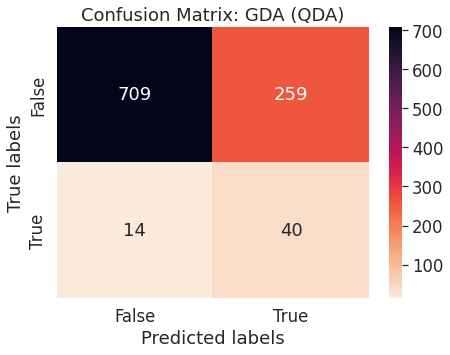

In [ ]:
phi, mu_0, mu_1, sigma_0, sigma_1 = qda_fit(X_train, y_train)

y_pred = qda_predict(X_test, phi, mu_0, mu_1, sigma_0, sigma_1)

models_score.append(["GDA", accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)]) # GDA SCORE

report = classification_report(y_test, y_pred)

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf_matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: GDA (QDA)')
sns.heatmap(cf_matrix, annot = True, fmt = "g", cmap = "rocket_r")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

print(report)

We can now compare QDA to LDA and see how QDA performs a little bit better.

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       968
           1       0.14      0.72      0.23        54

    accuracy                           0.74      1022
   macro avg       0.56      0.73      0.54      1022
weighted avg       0.94      0.74      0.81      1022



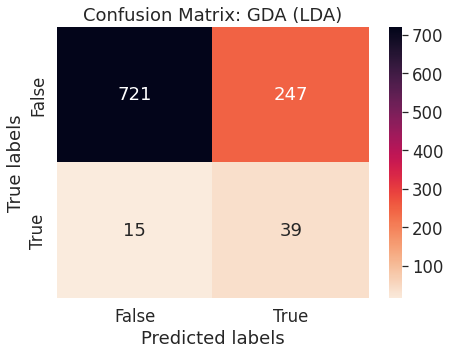

In [ ]:
phi, mu_0, mu_1, sigma = lda_fit(X_train, y_train)

y_pred = lda_predict(X_test, phi, mu_0, mu_1, sigma)

report = classification_report(y_test, y_pred)

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf_matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: GDA (LDA)')
sns.heatmap(cf_matrix, annot = True, fmt = "g", cmap = "rocket_r")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

print(report)

Let's verify if the data is normally distributed with the D’Agostino and Pearson’s normality test.

In [ ]:
from scipy.stats import normaltest

# Flatten the array to create a 1D sample
sample_0 = df[df.stroke == 0].values.flatten()
sample_1 = df[df.stroke == 1].values.flatten()

# Perform the Normaltest test
statistic_0, pvalue_0 = normaltest(sample_0)
statistic_1, pvalue_1 = normaltest(sample_1)

print(f"p-value for class 0: {pvalue_0}")
print(f"p-value for class 1: {pvalue_1}")

# If the p-value is greater than 0.05, it suggests that the data is likely to be Gaussian
if pvalue_0 > 0.05:
    print("Class 0 is likely to be Gaussian")
else:
    print("Class 0 is not likely to be Gaussian")

if pvalue_1 > 0.05:
    print("Class 1 is likely to be Gaussian")
else:
    print("Class 1 is not likely to be Gaussian")


p-value for class 0: 0.0
p-value for class 1: 1.9304748181889902e-162
Class 0 is not likely to be Gaussian
Class 1 is not likely to be Gaussian


From the normality test we can see that none of both classes are normally distributed.
If they were, Gaussian Discriminant Analysis would have had better performances.
We can assume that GDA performs quite good with respect to the other methods because the dataset has a small number of samples.

### 4.4 Support Vector Classification

We now try to see how a Support Vector Classifier works using SKLearn. We use a linear kernel:

Training Accuracy: 0.7718396711202467
Training Recall: 0.803186022610483
Testing Accuracy: 0.7563600782778865
Testing Recall: 0.6851851851851852


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

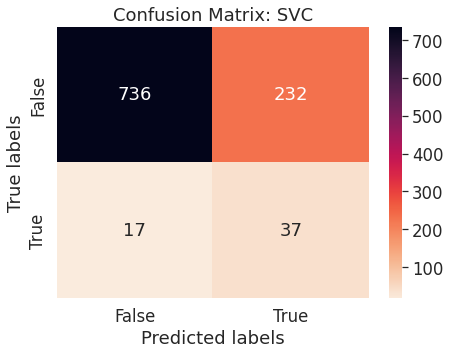

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

models_score.append(["SVC", accuracy_score(y_test, y_pred_test), recall_score(y_test, y_pred_test)]) # SVC SCORE

print('Training Accuracy:', accuracy_score(y_train, y_pred_train))
print('Training Recall:', recall_score(y_train, y_pred_train))
print('Testing Accuracy:', accuracy_score(y_test, y_pred_test))
print('Testing Recall:', recall_score(y_test, y_pred_test))

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf_matrix = confusion_matrix(y_test, y_pred_test)
plt.title('Confusion Matrix: SVC')
sns.heatmap(cf_matrix, annot = True, fmt = "g", cmap = "rocket_r")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

### 4.5 Random Forest Classifier

We now try to see how a Random Forest Classifier works using SKLearn. We use a maximum depth of 5:

Training Accuracy: 0.848792394655704
Training Recall: 0.9116135662898253
Testing Accuracy: 0.7837573385518591
Testing Recall: 0.6481481481481481


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

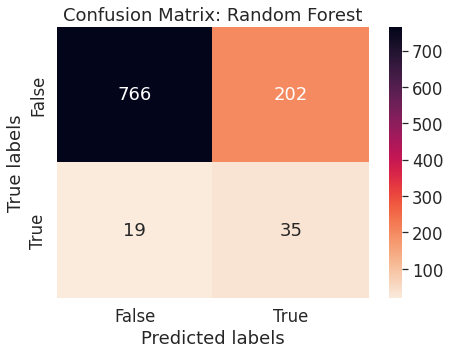

In [ ]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train, y_train)

y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

models_score.append(["RFC", accuracy_score(y_test, y_pred_test), recall_score(y_test, y_pred_test)]) # RFC SCORE

print('Training Accuracy:', accuracy_score(y_train, y_pred_train))
print('Training Recall:', recall_score(y_train, y_pred_train))
print('Testing Accuracy:', accuracy_score(y_test, y_pred_test))
print('Testing Recall:', recall_score(y_test, y_pred_test))

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf_matrix = confusion_matrix(y_test, y_pred_test)
plt.title('Confusion Matrix: Random Forest')
sns.heatmap(cf_matrix, annot = True, fmt = "g", cmap = "rocket_r")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])


# 5. Conclusions

[Text(0.5, 1.0, 'Recall score')]

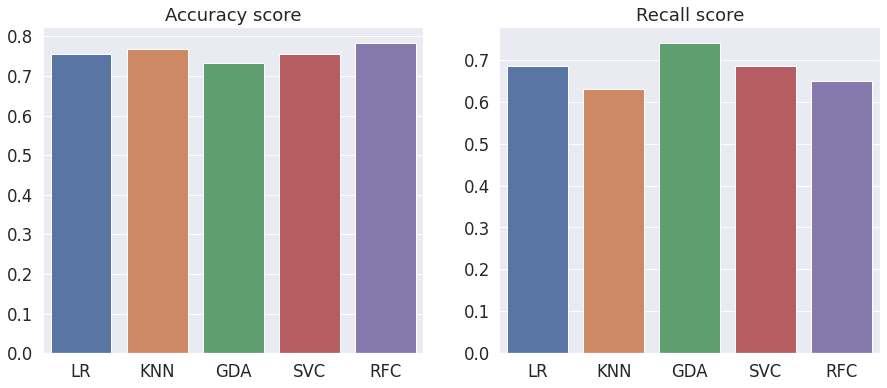

In [ ]:
# Barplot to show the test accuracy and recall scores of each algorithms
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.barplot(x = np.array(models_score)[:, 0], y=np.array(models_score)[:, 1].astype('float64'), ax=axes[0]).set(title='Accuracy score')
sns.barplot(x = np.array(models_score)[:, 0], y=np.array(models_score)[:, 2].astype('float64'), ax=axes[1]).set(title='Recall score')

In [ ]:
# metrics in details
for metric in models_score:
    print(np.array(metric)[0] + " Accuracy score: " + np.array(metric)[1])    
    print(np.array(metric)[0] + " Recall score: " + np.array(metric)[2] + "\n")  

LR Accuracy score: 0.7553816046966731
LR Recall score: 0.6851851851851852

KNN Accuracy score: 0.7671232876712328
KNN Recall score: 0.6296296296296297

GDA Accuracy score: 0.7328767123287672
GDA Recall score: 0.7407407407407407

SVC Accuracy score: 0.7563600782778865
SVC Recall score: 0.6851851851851852

RFC Accuracy score: 0.7837573385518591
RFC Recall score: 0.6481481481481481

